In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
import seaborn as sns

In [2]:
# Đường dẫn dữ liệu
data_path = '/kaggle/input/tiktok_comments_balanced.csv'

In [3]:
# Đọc dữ liệu
comments = pd.read_csv(data_path, usecols=['emotion_label', 'text'])
comments = comments.dropna(subset=['emotion_label'])
comments['emotion_label'] = comments['emotion_label'].astype(int)

# Không xử lý gì văn bản — giữ nguyên
comments['text'] = comments['text'].astype(str)

In [4]:
# Tokenizer và Model
model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

2025-05-21 16:21:09.194193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747844469.371657      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747844469.424275      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Mã hóa dữ liệu
encoded_comments = tokenizer.batch_encode_plus(
    comments['text'].tolist(),
    add_special_tokens=True,
    padding='max_length',
    max_length=128,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded_comments['input_ids']
attention_masks = encoded_comments['attention_mask']
labels = torch.tensor(comments['emotion_label'].values)

dataset = TensorDataset(input_ids, attention_masks, labels)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [6]:
# Chia tập train/val
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [7]:
save_directory = '/kaggle/working/phobert-base'
os.makedirs(save_directory, exist_ok=True)

In [8]:
# Thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Tính class weights
all_labels = []
for batch in train_loader:
    _, _, labels = batch
    all_labels.extend(labels.numpy())
all_labels = np.array(all_labels)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 10
patience = 3
best_accuracy = 0
patience_counter = 0

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    true_labels, pred_labels = [], []
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            pred_labels.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = accuracy_score(true_labels, pred_labels)
    val_accuracies.append(accuracy)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

    # Early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': accuracy,
            'loss': avg_val_loss
        }, "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping tại epoch {epoch+1} (val_acc không cải thiện sau {patience} epoch)")
            break

print("\nTraining completed!")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Lưu model
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Training Epoch 1:   0%|          | 0/813 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 1.0744 | Val Loss: 0.9526 | Val Accuracy: 0.6349


Training Epoch 2:   0%|          | 0/813 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/91 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 0.8011 | Val Loss: 0.8933 | Val Accuracy: 0.6729


Training Epoch 3:   0%|          | 0/813 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/91 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 0.5995 | Val Loss: 1.0477 | Val Accuracy: 0.6584


Training Epoch 4:   0%|          | 0/813 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/91 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 0.4727 | Val Loss: 1.1187 | Val Accuracy: 0.6639


Training Epoch 5:   0%|          | 0/813 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/91 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 0.3251 | Val Loss: 1.2311 | Val Accuracy: 0.6715
Early stopping tại epoch 5 (val_acc không cải thiện sau 3 epoch)

Training completed!
Best Validation Accuracy: 0.6729


('/kaggle/working/phobert-base/tokenizer_config.json',
 '/kaggle/working/phobert-base/special_tokens_map.json',
 '/kaggle/working/phobert-base/vocab.txt',
 '/kaggle/working/phobert-base/bpe.codes',
 '/kaggle/working/phobert-base/added_tokens.json')

In [9]:
# Dự đoán mẫu
label_names = {
    0: 'Vui vẻ',
    1: 'Tức giận',
    2: 'Buồn bã',
    3: 'Sợ hãi',
    4: 'Trung lập'
}

In [10]:
print(classification_report(true_labels, pred_labels, target_names=list(label_names.values())))

              precision    recall  f1-score   support

      Vui vẻ       0.60      0.55      0.57       307
    Tức giận       0.68      0.68      0.68       297
     Buồn bã       0.66      0.68      0.67       287
      Sợ hãi       0.76      0.89      0.82       270
   Trung lập       0.64      0.59      0.61       285

    accuracy                           0.67      1446
   macro avg       0.67      0.68      0.67      1446
weighted avg       0.67      0.67      0.67      1446



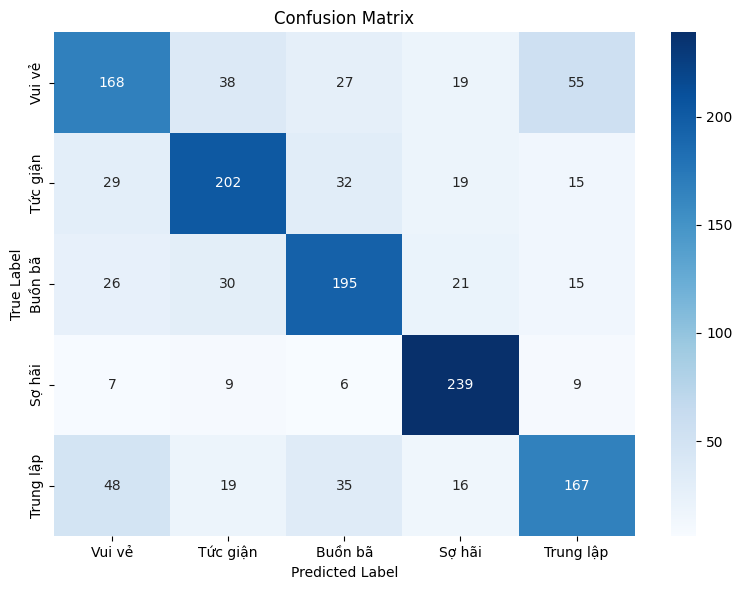

In [11]:
# Ma trận nhầm lẫn
cm = confusion_matrix(true_labels, pred_labels)
labels = list(label_names.values())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [12]:
# Load lại mô hình tốt nhất từ file .pth
checkpoint = torch.load("best_model.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.to(device)
print(f"\nĐã load mô hình tốt nhất tại epoch {checkpoint['epoch']} với val_acc = {checkpoint['val_accuracy']:.4f}")


Đã load mô hình tốt nhất tại epoch 2 với val_acc = 0.6729


In [13]:
print("\n--- Examples of Predictions ---")
for i in range(10):
    pred = pred_labels[i]
    true = true_labels[i]
    text = comments.iloc[val_dataset.indices[i]]['text']
    status = "✅ Correct" if pred == true else "❌ Incorrect"
    print(f"{status} | Text: {text}\n  Predicted: {label_names[pred]}, Actual: {label_names[true]}\n")



--- Examples of Predictions ---
✅ Correct | Text: xe đậu bên đường thản_nhiên ghê_ko dẫn đi
  Predicted: Tức giận, Actual: Tức giận

✅ Correct | Text: t xuống t nch từng thằng
  Predicted: Tức giận, Actual: Tức giận

✅ Correct | Text: pha nhục đi vào thế_kỉ
  Predicted: Tức giận, Actual: Tức giận

✅ Correct | Text: mong pháp_luật xử thật nặng dăn_đe cho các bạn trẻ sáng_mắt ra
  Predicted: Tức giận, Actual: Tức giận

✅ Correct | Text: ngầu
  Predicted: Vui vẻ, Actual: Vui vẻ

✅ Correct | Text: ui sợ dơn
  Predicted: Sợ hãi, Actual: Sợ hãi

❌ Incorrect | Text: xã_hội đáng sợ
  Predicted: Sợ hãi, Actual: Buồn bã

✅ Correct | Text: tim để gia_đình hạnh_phúc bình_an
  Predicted: Vui vẻ, Actual: Vui vẻ

❌ Incorrect | Text: chắc nó đang mắc nợ nên cố_tình làm_vậy để dc vô tò_ăn cơm cữ cho an_toàn ấy mà
  Predicted: Buồn bã, Actual: Trung lập

✅ Correct | Text: quá tội át
  Predicted: Tức giận, Actual: Tức giận



In [14]:
def predict_text(text):
    model.eval()
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        max_length=128,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids'].to(model.device)
    attention_mask = encoded['attention_mask'].to(model.device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    print(f"\n Dự đoán cảm xúc: {label_names[predicted_class]}")


In [15]:
test_texts = [
    "nghe bạn nam bảo : khổ thế nhờ đã dịch cô vít thì chớ mà xót🥺",
    "mày giỡn mặt tao à?",
    "trời ơi vui quá đi 😍 hôm nay được nghỉ học",
    "bạn nữ đó nhìn buồn thật sự",
    "tôi cảm thấy lo lắng khi ra đường bây giờ",
    "haiz, chẳng còn gì để nói nữa",
    "mấy bạn bình tĩnh, chuyện đâu còn có đó",
    "cảm ơn bạn rất nhiều vì đã giúp tôi",
    "tôi ghét cái cách bạn đối xử với tôi",
    "mình rất hồi hộp chờ kết quả thi"
]

for text in test_texts:
    print(f"\n Bình luận: {text}")
    predict_text(text)



 Bình luận: nghe bạn nam bảo : khổ thế nhờ đã dịch cô vít thì chớ mà xót🥺

 Dự đoán cảm xúc: Buồn bã

 Bình luận: mày giỡn mặt tao à?

 Dự đoán cảm xúc: Tức giận

 Bình luận: trời ơi vui quá đi 😍 hôm nay được nghỉ học

 Dự đoán cảm xúc: Vui vẻ

 Bình luận: bạn nữ đó nhìn buồn thật sự

 Dự đoán cảm xúc: Buồn bã

 Bình luận: tôi cảm thấy lo lắng khi ra đường bây giờ

 Dự đoán cảm xúc: Sợ hãi

 Bình luận: haiz, chẳng còn gì để nói nữa

 Dự đoán cảm xúc: Buồn bã

 Bình luận: mấy bạn bình tĩnh, chuyện đâu còn có đó

 Dự đoán cảm xúc: Vui vẻ

 Bình luận: cảm ơn bạn rất nhiều vì đã giúp tôi

 Dự đoán cảm xúc: Vui vẻ

 Bình luận: tôi ghét cái cách bạn đối xử với tôi

 Dự đoán cảm xúc: Tức giận

 Bình luận: mình rất hồi hộp chờ kết quả thi

 Dự đoán cảm xúc: Vui vẻ


In [16]:
!zip -r /kaggle/working/phobert-base.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/phobert-base/ (stored 0%)
  adding: kaggle/working/phobert-base/special_tokens_map.json (deflated 57%)
  adding: kaggle/working/phobert-base/bpe.codes (deflated 59%)
  adding: kaggle/working/phobert-base/config.json (deflated 53%)
  adding: kaggle/working/phobert-base/added_tokens.json (stored 0%)
  adding: kaggle/working/phobert-base/model.safetensors (deflated 16%)
  adding: kaggle/working/phobert-base/tokenizer_config.json (deflated 77%)
  adding: kaggle/working/phobert-base/vocab.txt (deflated 55%)
  adding: kaggle/working/best_model.pth (deflated 30%)
